<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Feature engineering

> Authors: Lim Zheng Gang, Eugene Matthew Cheong, Pius Yee

---

### Notebook 2. Feature engineering:

##### In Notebook 1, we cleaned the dataset and exported it as a CSV file. Now, in Notebook 2, we'll perform feature engineering to build a model that predicts HDB flat resale prices from the cleaned dataset.

In [1]:
# import libraries

from datetime import datetime
import math

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import scipy
from scipy.stats import pearsonr
from scipy.spatial.distance import cityblock

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import category_encoders as ce


pd.set_option('display.max_columns', None)

In [2]:
# read the cleaned dataset from Notebook 1
hdb_df = pd.read_csv("../datasets/hdb_cleaned.csv", index_col=0)
hdb_df.head(3)

,id,flat_type,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,4 ROOM,Model A,2006,680000.0,2016,5,11,968.760,15,25,2005,0,0,0,0,142,0,0,0,96,46,0,0,0,1.314299,103.872828,Kallang,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,122598,5 ROOM,Improved,1987,665000.0,2012,7,8,1399.320,34,9,1987,0,0,0,0,112,0,0,0,56,56,0,0,0,1.346086,103.855078,Bishan,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,1,1,58.207761,415.607357,45,1,447.894399,232,0
2,170897,EXECUTIVE,Apartment,1997,838000.0,2013,7,14,1550.016,24,16,1996,0,0,0,0,90,0,0,0,0,30,60,0,0,1.343867,103.760535,Bukit Batok,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,1,0,214.747860,498.849039,39,0,180.074558,188,0


##### Planning area is a valuable piece of information, but it encompasses a wide range of variables. To address this complexity, we've categorized these variables into groups like 'mature/non-mature' and grouping based on average resale price.

In [3]:
# new column for mature/non mature estate
#another new column for area category
mature_lst = ["Ang Mo Kio","Bedok","Bishan","Bukit Merah","Bukit Timah","Clementi","Downtown Core","Geylang","Kallang","Marine Parade", "Novena", "Outram", "Pasir Ris", "Queenstown", "Rochor","Serangoon","Tampines","Tanglin","Toa Payoh"]
area_category_mapping = {
    'Tanglin': "Group1",
    'Bukit Timah': "Group1",
    'Outram': "Group1",
    'Downtown Core': "Group1",
    'Bishan': "Group1",
    'Bukit Merah': "GroupJB",
    'Queenstown': "GroupCQS",
    'Marine Parade': "GroupCM",
    'Kallang': "Group2",
    'Pasir Ris': "Group2",
    'Serangoon': "GroupCQS",
    'Toa Payoh': "Group2",
    'Tampines': "Group2",
    'Punggol': "Group2",
    'Clementi': "GroupCQS",
    'Rochor': "Group2",
    'Sengkang': "Group2",
    'Novena': "Group2",
    'Hougang': "GroupYH",
    'Bukit Panjang': "GroupPWC",
    'Western Water Catchment': "Group2",
    'Geylang': "Group2",
    'Jurong East': "GroupJB",
    'Bedok': "Group2",
    'Ang Mo Kio': "GroupA",
    'Choa Chu Kang': "GroupPWC",
    'Sembawang': "Group3",
    'Jurong West': "Group3",
    'Woodlands': "GroupPWC",
    'Bukit Batok': "Group3",
    'Yishun': "GroupYH",
    'Changi': "GroupCM"
}

hdb_df["mature"] = hdb_df["planning_area"].apply(lambda x: 1 if x in mature_lst else 0)
hdb_df['planning_area_category'] = hdb_df['planning_area'].map(area_category_mapping)
hdb_df = pd.get_dummies(hdb_df, columns=['planning_area_category'], dtype="int")
hdb_df = hdb_df.drop(columns=['planning_area','planning_area_category_Group2','planning_area_category_Group3'])


##### Since our understanding of the housing market suggests that tenure ("transaction year" less "lease commencement date") can influence HDB prices, we've incorporated new columns for tenure in the dataset.

In [4]:
# new column for "tenure"
hdb_df["tenure"] = hdb_df["Tranc_Year"] - hdb_df["lease_commence_date"]
hdb_df = hdb_df.drop(columns=["lease_commence_date"]) #drop lease commencement date since we have the new column "tenure"

In [5]:
# new column for "tenure bucket" since the first 10 years have better resale price

bin_edges = list(range(0, hdb_df["tenure"].max() + 6, 5))

# Create labels for the bins
bin_edges = [0,11, hdb_df["tenure"].max() + 1]

# Create labels for the bins
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

# Apply pd.cut to create buckets
hdb_df["tenure_buckets"] = pd.cut(hdb_df["tenure"], bins=bin_edges, labels=bin_labels, include_lowest=True, right=False)

# Display the DataFrame with the new tenure_buckets column
print(hdb_df[["tenure", "tenure_buckets"]])

# Get dummies for buckets
hdb_df = pd.get_dummies(hdb_df, columns=["tenure_buckets"],dtype='int')

# Keep tenure bucket 1-10 only, since it tends to have a higher resale price
hdb_df = hdb_df.drop(columns=["tenure_buckets_11-54"])

        tenure tenure_buckets
0           10           0-10
1           25          11-54
2           16          11-54
3           20          11-54
4           30          11-54
...        ...            ...
149800      25          11-54
149801      16          11-54
149802      27          11-54
149803      42          11-54
149804      31          11-54

[149805 rows x 2 columns]


##### Based on historical data on HDB resale price movements, we classified years into Groups 1 to 3.
##### Group 0 represents the lowest price point, while Group 3 represents the highest.

In [6]:
# category for year based on resale price trend
year_category_mapping = {
    2012 : "Group3",
    2013: "Group3",
    2014: "Group2",
    2015: "Group1",
    2016: "Group1",
    2017: "Group2",
    2018: "Group1",
    2019: "Group0",
    2020: "Group2",
    2021: "Group3"

}

# adding new columns for year category
hdb_df['year_category'] = hdb_df['Tranc_Year'].map(year_category_mapping)
hdb_df = pd.get_dummies(hdb_df, columns=['year_category'],dtype='int')
hdb_df = hdb_df.drop(columns=["year_category_Group3"])


##### Based on the model tuning, we found a few flat models and flat types have high correlation as follows:-

In [7]:
# Flat model "Improved-Maisonette" and "DBSS"
hdb_df["is_premium"] = hdb_df["flat_model"].map(lambda x: 1 if x in  ("Improved-Maisonette","DBSS") else 0)

# Flat model "Terrace""
hdb_df["is_terrace"] = hdb_df["flat_model"].map(lambda x: 1 if x ==  "Terrace" else 0)

# Terrace larger than 2250 sqft
hdb_df["is_superlargeterrace"] = hdb_df["floor_area_sqft"].map(lambda x: 1 if x >= 2250 else 0)

# Flat types with 1-room and 2-room
hdb_df = pd.get_dummies(hdb_df, columns=['flat_type'], prefix='flat_type', dtype="int")
hdb_df = hdb_df.drop(columns=['flat_type_3 ROOM','flat_type_4 ROOM','flat_type_5 ROOM','flat_type_EXECUTIVE','flat_type_MULTI-GENERATION'])

# Flats before war i.e. 1949 tends to have higher resale price
hdb_df["is_pre_war"] = hdb_df["year_completed"].map(lambda x : 1 if x == 1949 else 0)
hdb_df = hdb_df.drop(columns=['year_completed'])

# drop flat model column
hdb_df = hdb_df.drop(columns=['flat_model'])


##### Distance from the central area is a key factor in predicting HDB flat prices. We set GA campus as the central area.

In [8]:
#define a function to calcualte the distance from central

def calculate_distance(lat1, lng1, lat2, lng2):
    R = 6371  # Earth radius in kilometers
    dlat = np.radians(lat2 - lat1)
    dlng = np.radians(lng2 - lng1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlng / 2) * np.sin(dlng / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance_km = R * c
    return distance_km

In [9]:
# GA campus set as the central.

#longitude and Lattitude for GA campus
lat1 = 1.2742738490494008 
lng1 =  103.84567324086873

#new columns for centre distance
hdb_df["from_centre_distance"] = calculate_distance(lat1, lng1, hdb_df["Latitude"], hdb_df["Longitude"])

##### Based on our experiment, we found that a few malls specifically affect nearby HDB resale prices. We added a column named "mh" to show the distance to the nearest supermall.

In [10]:
# Working for computing distance to supermalls
df_sm_location = pd.read_csv("../datasets/sm_location_supermalls.csv")

df_mh_calculation = pd.DataFrame()
df_mh_calculation["id"] = hdb_df["id"]
df_mh_calculation["lat"] = hdb_df["Latitude"]
df_mh_calculation["lng"] = hdb_df["Longitude"]

for each_id in df_mh_calculation["id"].values:
    lat1 = df_mh_calculation.loc[df_mh_calculation[df_mh_calculation["id"]==each_id].index, "lat"].iloc[0]
    lng1 = df_mh_calculation.loc[df_mh_calculation[df_mh_calculation["id"]==each_id].index, "lng"].iloc[0]

    latitudes = df_sm_location["LATITUDE"].values
    longitudes = df_sm_location["LONGITUDE"].values

    distances = calculate_distance(lat1, lng1, latitudes, longitudes)

    min_dist_mall = np.min(distances)

    df_mh_calculation.loc[df_mh_calculation[df_mh_calculation["id"]==each_id].index, "mh"] = min_dist_mall
    
df_mh_calculation.to_csv('../datasets/supermh_test.csv', index=False) # to avoid running above loop again
hdb_df = pd.merge(hdb_df, df_mh_calculation[['id', 'mh']], on='id', how='left')

hdb_df = hdb_df.drop(columns=["Latitude","Longitude"])

##### We then analyze and drop the features that exhibit low correlation with the target variable.

In [11]:
# to check for very low coef features

col_to_keep = ["resale_price",'flat_type_2 ROOM','year_category_Group1','year_category_Group2','year_category_Group0','planning_area_category_GroupCM','is_superlargeterrace','flat_type_1 ROOM',"is_pre_war"] # keeping the features for modelling

for each_x in hdb_df.drop(col_to_keep,axis=1).columns:
            if (hdb_df["resale_price"].corr(hdb_df[each_x]) < 0.05) and (hdb_df["resale_price"].corr(hdb_df[each_x]) > -0.05):
                print(each_x,hdb_df["resale_price"].corr(hdb_df[each_x]))
                hdb_df = hdb_df.drop(columns=each_x)

Tranc_Year -0.02467858584355618
Tranc_Month -0.0056850599449805184
market_hawker -0.005925116982023568
multistorey_carpark -0.007767356443814828
precinct_pavilion -0.0013671580335734238
1room_sold -0.03948787703565454
multigen_sold 0.03760779236159183
studio_apartment_sold 0.041588531129178666
Hawker_Nearest_Distance -0.016077782454305033
Hawker_Within_500m 0.01303716241700006
hawker_food_stalls -0.03289905083484202
hawker_market_stalls -0.008555041388109443
bus_interchange 0.003276930894604897
bus_stop_nearest_distance 0.030545988008687037
pri_sch_nearest_distance -0.010870662594068957
vacancy -0.01704207929809686
pri_sch_affiliation 0.03132795731277339
cutoff_point 0.036112066689200945
affiliation -0.0006445223971269946


##### Based on our experiments, we selectively remove columns that provide minimal or no benefit to our model's performance.

In [12]:
# Dropping the features that provide no or minimal benefits

columns_to_drop= ['total_dwelling_units', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km',
       'Mall_Within_2km', 'Hawker_Within_1km', 'Hawker_Within_2km',
       'mrt_interchange', 'sec_sch_nearest_dist','hdb_age','commercial']

hdb_df = hdb_df.drop(columns=columns_to_drop)

##### Following an iterative process of evaluating and refining features, we have arrived at the final dataset for our modelas below:

In [13]:
hdb_df.to_csv("../datasets/hdb_final.csv") # export the final dataset to CSV
hdb_df.head()

,id,resale_price,mid,floor_area_sqft,max_floor_lvl,mrt_nearest_distance,mature,planning_area_category_Group1,planning_area_category_GroupA,planning_area_category_GroupCM,planning_area_category_GroupCQS,planning_area_category_GroupJB,planning_area_category_GroupPWC,planning_area_category_GroupYH,tenure,tenure_buckets_0-10,year_category_Group0,year_category_Group1,year_category_Group2,is_premium,is_terrace,is_superlargeterrace,flat_type_1 ROOM,flat_type_2 ROOM,is_pre_war,from_centre_distance,mh
0,88471,680000.0,11,968.760,25,330.083069,1,0,0,0,0,0,0,0,10,1,0,1,0,0,0,0,0,0,0,5.377752,1.037743
1,122598,665000.0,8,1399.320,9,903.659703,1,1,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,8.053298,0.855884
2,170897,838000.0,14,1550.016,16,1334.251197,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,12.225337,1.786453
3,86070,550000.0,3,1108.692,11,907.453484,1,1,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,9.337205,0.959522
4,153632,298000.0,2,893.412,4,412.343032,0,0,0,0,0,0,0,1,30,0,0,0,1,0,0,0,0,0,0,15.660288,1.502249


### Data Dictionary

##### *(i) General features*


|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|int64|train.csv|Transaction ID for HDB resale|
|resale_price|float64|train.csv|Resale price of the HDB transaction|
|mid|int64|train.csv|Middle floor from the range of floor level|
|floor_area_sqft|float64|train.csv|Floor size of the HDB flat|
|max_floor_lvl|int64|train.csv|Max floor level for the block of transacted unit|

##### *(ii) Distance related features*


|Feature|Type|Dataset|Description|
|---|---|---|---|
|mrt_nearest_distance|float64|train.csv|Distance to the nearest MRT|
|from_centre_distance|float64|train.csv|Distance from Central area. GA campus set as the central area|
|mh|float64|sm_location_supermalls.csv|Distance to supermall i.e. the popular malls with very high number of customers|

##### *(iii) Planning Area related features*


|Feature|Type|Dataset|Description|
|---|---|---|---|
|mature|int64|train.csv|Mature HDB estate|
|planning_area_category_Group1|int64|train.csv|Includes areas such as Tanglin, Bukit Timah, Outram, Downtown Core, Bishan.|
|planning_area_category_GroupA|int64|train.csv|Includes areas such as Ang Mo Kio.|
|planning_area_category_GroupCM|int64|train.csv|Includes areas such as Marine Parade, Changi. |
|planning_area_category_GroupCQS|int64|train.csv|Includes areas such as Queenstown, Serangoon, Clementi.|
|planning_area_category_GroupJB|int64|train.csv|Includes areas such as Bukit Merah, Jurong East.|
|planning_area_category_GroupPWC|int64|train.csv|Includes areas such as Bukit Panjang, Choa Chu Kang, Woodlands.|
|planning_area_category_GroupYH|int64|train.csv|Includes areas such as Hougang, Yishun.|

##### *(iv) Time related features*


|Feature|Type|Dataset|Description|
|---|---|---|---|
|tenure|int64|train.csv|Transaction year less lease commencement year|
|tenure_buckets_0-10|int64|train.csv|Tenure bucket for 0 to 10 years|
|year_category_Group0|int64|train.csv|Year categories by the resale price trend. Group 0 is the years with lowest avg resale price|
|year_category_Group1|int64|train.csv|Year categories by the resale price trend. Group 1 is the years with 2nd lowest avg resale price|
|year_category_Group2|int64|train.csv|<Year categories by the resale price trend. Group 0 is the years with 2nd highest avg resale price>|
|is_pre_war|int64|train.csv|Flat built before war i.e. 1949|

##### *(v)Flat types related features*


|Feature|Type|Dataset|Description|
|---|---|---|---|
|is_premium|int64|train.csv|Flat model is DBSS or Improved-Maisonette|
|is_terrace|int64|train.csv|Landed terrace HDB|
|is_superlargeterrace|int64|train.csv|Terrace with size more than 2250 sqft|
|flat_type_1 ROOM|int64|train.csv|1-room flat|
|flat_type_2 ROOM|int64|train.csv|2-room flat|

##### The final scores for our features are as below:

In [14]:
lr = LinearRegression()

In [15]:
# Calculate scores for Linear Regression
scaler = StandardScaler()

X= hdb_df.drop(columns=['id','resale_price'])
y = hdb_df['resale_price'].values 

X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), np.log1p(y), random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

{"r2": metrics.r2_score(y_test, y_pred) ,"r2 for train set": lr.score(X_train,y_train), "r2 for test set": lr.score(X_test,y_test), "cross val": cross_val_score(lr, X_train, y_train, cv=10).mean(), "MSE": metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1),"RMSE": metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1, squared=False),"MAE": metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1)}


{'r2': 0.9014830336943288,
 'r2 for train set': 0.9029794493544212,
 'r2 for test set': 0.9014830336943288,
 'cross val': 0.9028576427120022,
 'MSE': 2103703193.9541633,
 'RMSE': 45866.14431096387,
 'MAE': 33525.436789583386}

In [16]:
f'The total columns for final dataframe is {hdb_df.columns.value_counts().sum()}'

'The total columns for final dataframe is 27'

##### The overall OLS Regression Results

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the standardized array back to a DataFrame with column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add a constant term to the feature matrix for the intercept
X_with_intercept = sm.add_constant(X_scaled_df)

# Fit the linear regression model using statsmodels
model = sm.OLS(np.log1p(y), X_with_intercept).fit()

# Display the summary which includes p-values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 5.553e+04
Date:                Wed, 13 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:00:02   Log-Likelihood:             1.4120e+05
No. Observations:              149805   AIC:                        -2.824e+05
Df Residuals:                  149779   BIC:                        -2.821e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

### The model requires that certain assumptions are met for its results to be reliable, which including:
##### *(1) L - Linear relationship*
##### *(2) I - Independent errors*
##### *(3) N - Normally distributed errors*
##### *(4) E - Equal variance of errors (homoscedasticity)*
##### *(5) M - No Multicollinearity/Independence of Predictors*

--------



##### **(1) L - Linear relationship**
##### Relationship between features and resale price should be approximately linear.
##### Based on the correlation coefficient below, there are linear correlation exists between features and resale price.

In [18]:
hdb_df.corr().iloc[:,1:2].sort_values(by="resale_price")

,resale_price
tenure,-0.360510
from_centre_distance,-0.257900
flat_type_2 ROOM,-0.160203
mh,-0.133778
mrt_nearest_distance,-0.127939
planning_area_category_GroupYH,-0.113903
planning_area_category_GroupPWC,-0.105585
planning_area_category_GroupA,-0.052852
year_category_Group1,-0.049638
year_category_Group0,-0.042039


-------
##### **(2) I - Independent errors**
##### The features should be Independence between each others
##### We performed the test together with point "(5) M/I: No Multicollinearity/Independence of Predictors" below.


-------
##### **(3) N - Normally distributed errors**
##### The residuals should be normal distributed.

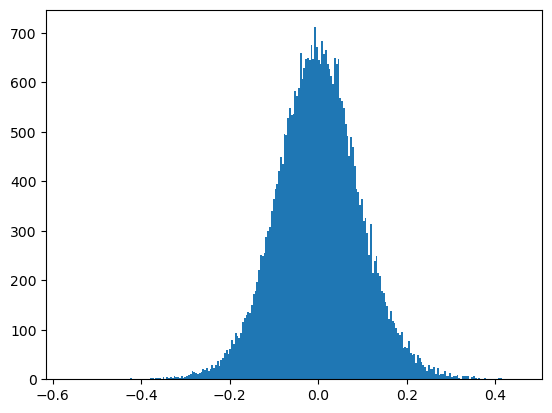

In [19]:
# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot the residual graph
plt.hist(residuals,bins=250)
plt.show()


##### Based on the histogram above, it is a normal distribution.

-----
##### **(4) E - Equal variance of errors**
##### To check whether if absolute randomness is observed in the residual plots
##### 

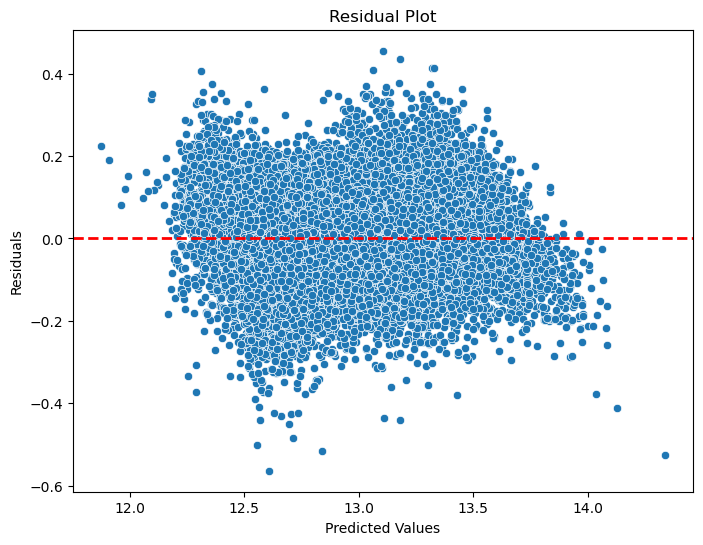

In [20]:
# Plot the residual graph
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


---
##### **(5) M/I: No Multicollinearity/Independence of Predictors**
##### VIF (Variance Inflation Factor) is a good diagnostic tool to assess multicollinearity among independent variables in a regression model.
##### 

In [21]:
# create a VIF dataframe to perform the test
vif_data = pd.DataFrame() 

scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)

vif_data["feature"] = X.columns
  
vif_data["VIF"] = [variance_inflation_factor(X_scaled2, i) 
                   for i in range(X_scaled2.shape[1])]

print(vif_data)

                            feature       VIF
0                               mid  1.446172
1                   floor_area_sqft  1.414560
2                     max_floor_lvl  2.294539
3              mrt_nearest_distance  1.228947
4                            mature  3.486414
5     planning_area_category_Group1  1.150664
6     planning_area_category_GroupA  1.247850
7    planning_area_category_GroupCM  1.121903
8   planning_area_category_GroupCQS  1.260190
9    planning_area_category_GroupJB  1.375186
10  planning_area_category_GroupPWC  1.411047
11   planning_area_category_GroupYH  1.373131
12                           tenure  3.316537
13              tenure_buckets_0-10  2.404530
14             year_category_Group0  1.350745
15             year_category_Group1  1.598793
16             year_category_Group2  1.609572
17                       is_premium  1.116697
18                       is_terrace  1.045074
19             is_superlargeterrace  1.036253
20                 flat_type_1 ROO

##### Based on the VIF results above, the highest VIF is less than 4.
##### VIF < 5 indicates it is acceptable, little to no concern about multicollinearity.

##### All the assumptions above have been verified.

### EDA

##### Boxplots for categorical features as below:

##### Boxplots for planning area related features:-

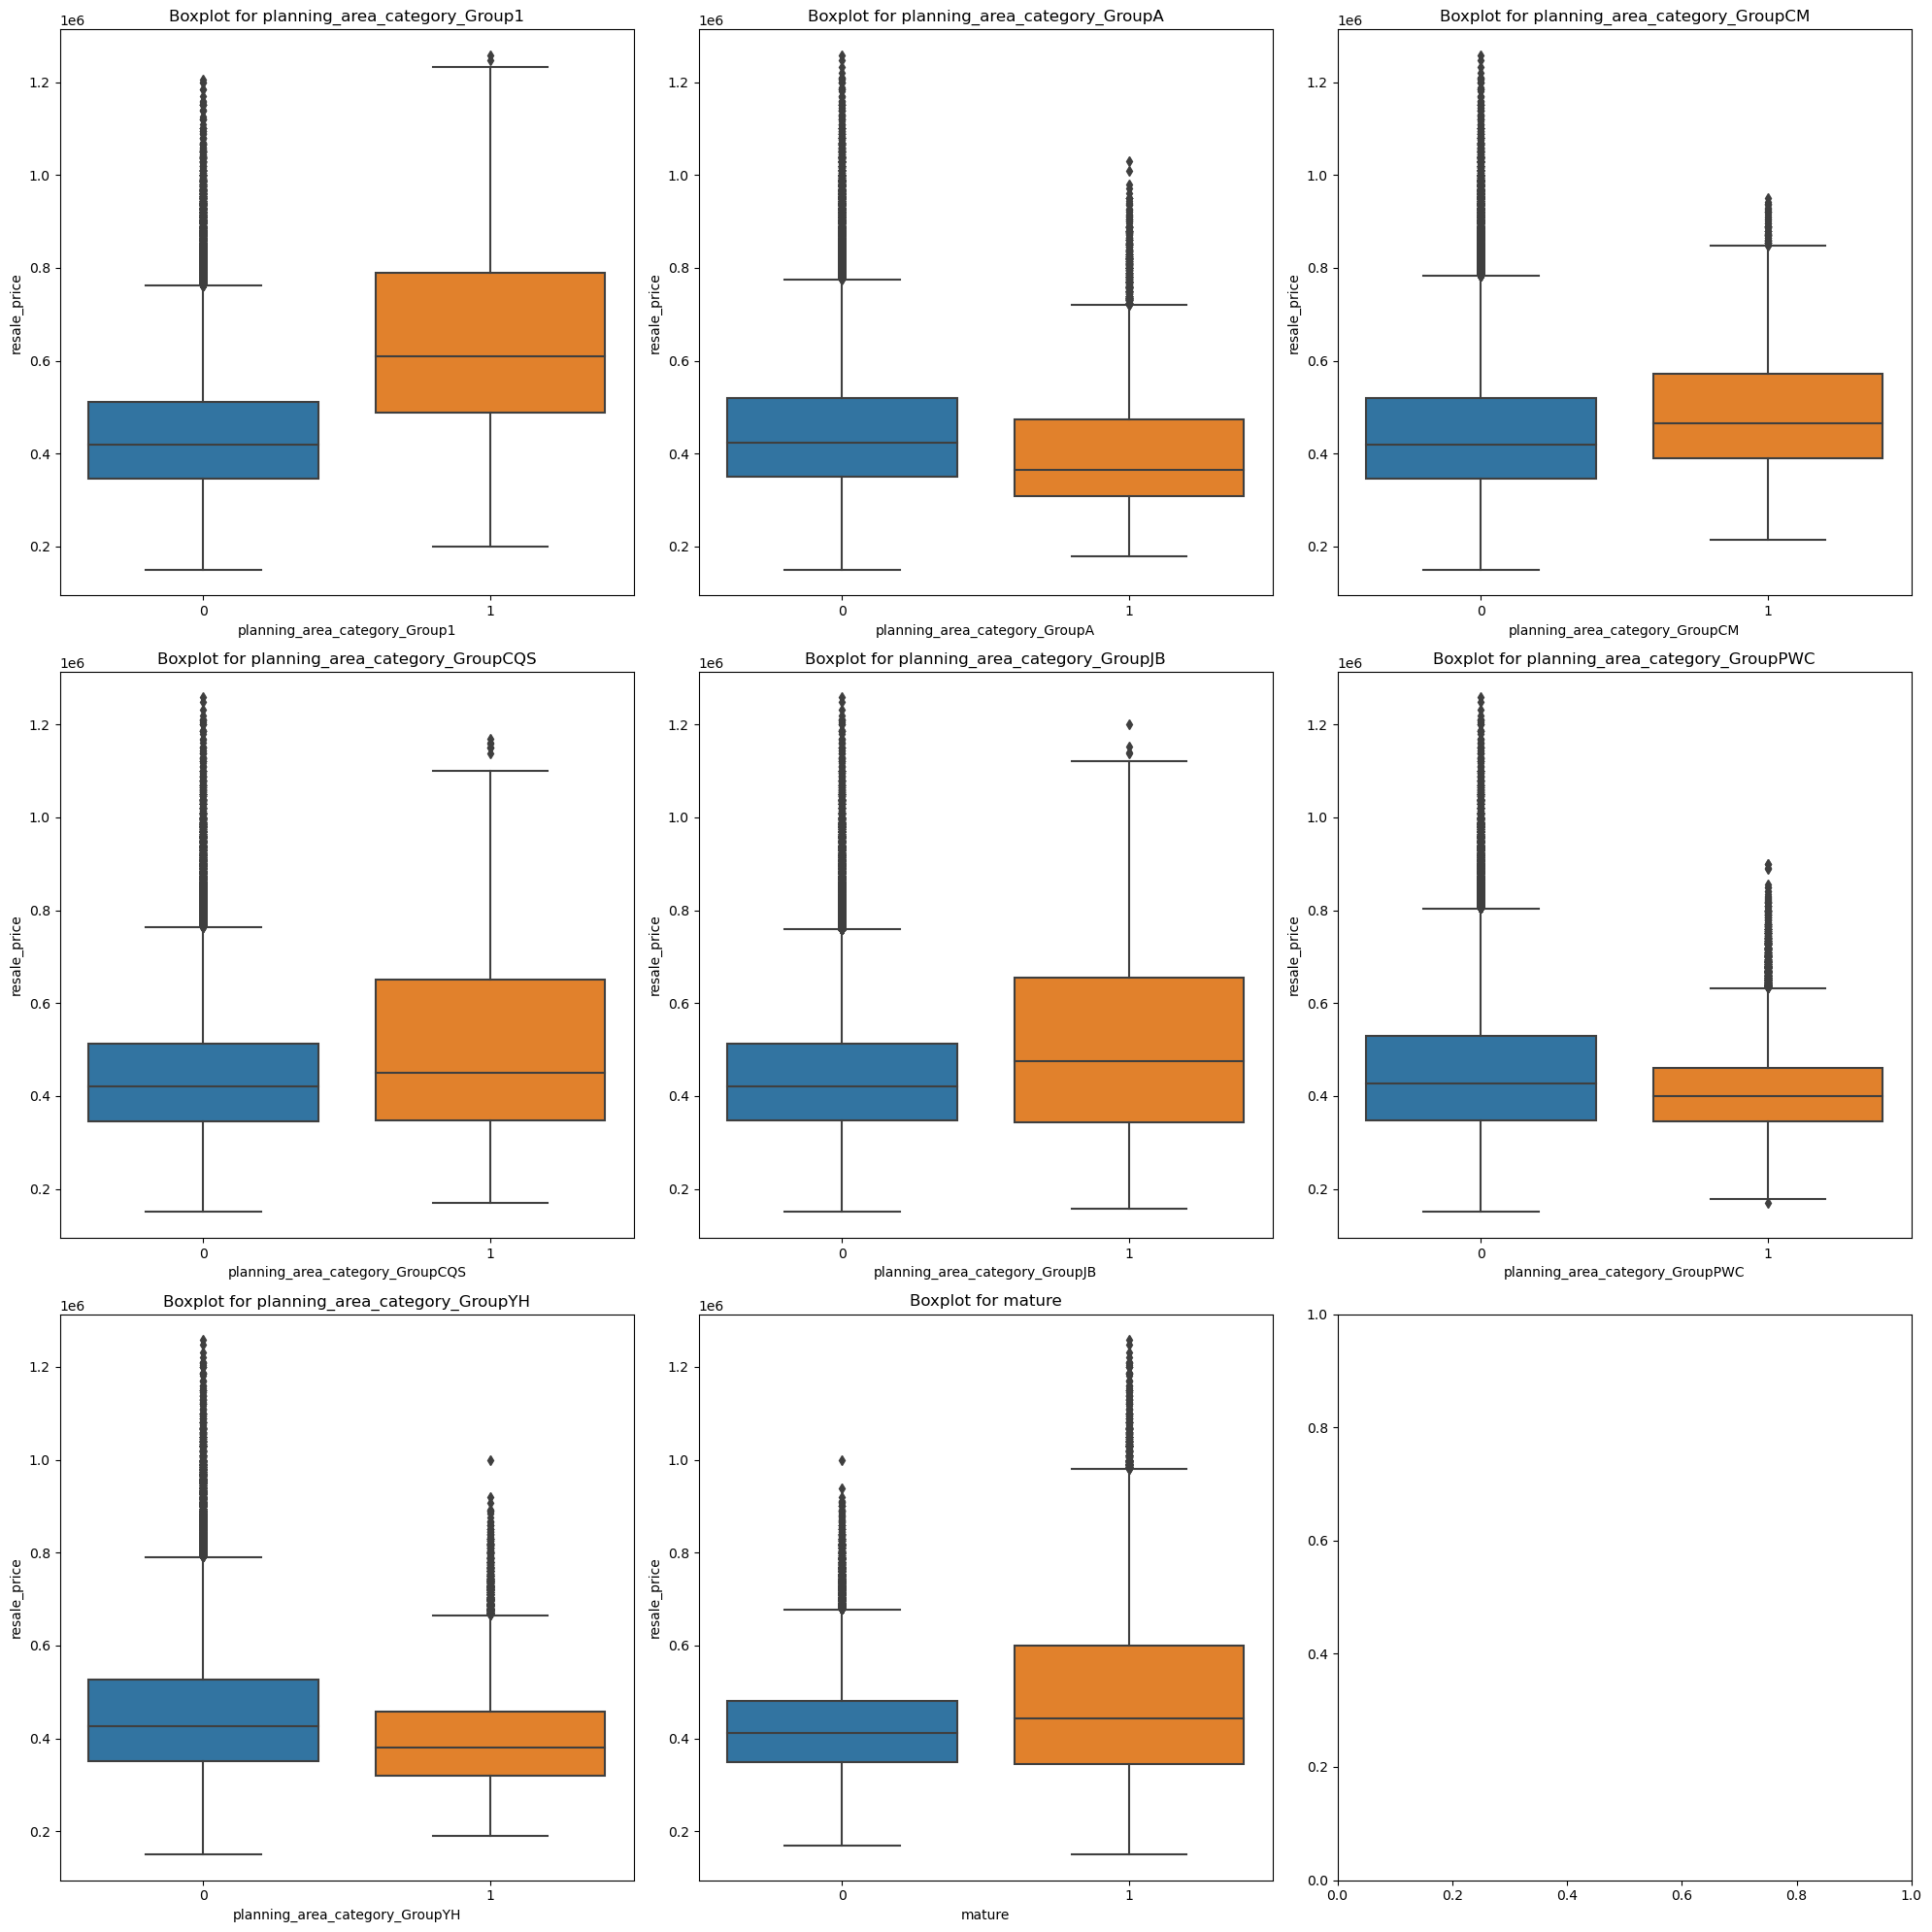

In [22]:
# Boxplots for planning area related features
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust rows, cols, and figsize as needed

row_count = 0
col_count = 0


for i in [
       'planning_area_category_Group1',
       'planning_area_category_GroupA', 'planning_area_category_GroupCM',
       'planning_area_category_GroupCQS', 'planning_area_category_GroupJB',
       'planning_area_category_GroupPWC', 'planning_area_category_GroupYH', 'mature'
       ]:
   
   sns.boxplot(data=hdb_df , x = i, y = 'resale_price', ax=axes[row_count,col_count])
   axes[row_count,col_count].set_title("Boxplot for "+i)
   col_count += 1
   if col_count == 3:
      row_count += 1
      col_count = 0

# Adjust layout
sns.set_palette("Set3")
plt.tight_layout()
plt.show()

##### Based on the boxplots above, the planning area is one of the important features to predict HDB resale price. We grouped the areas based on the average resale price (refer to data dictionary in this notebook for more details). Different categories of area affect the resale price. 

------

##### Boxplots for time related features:-


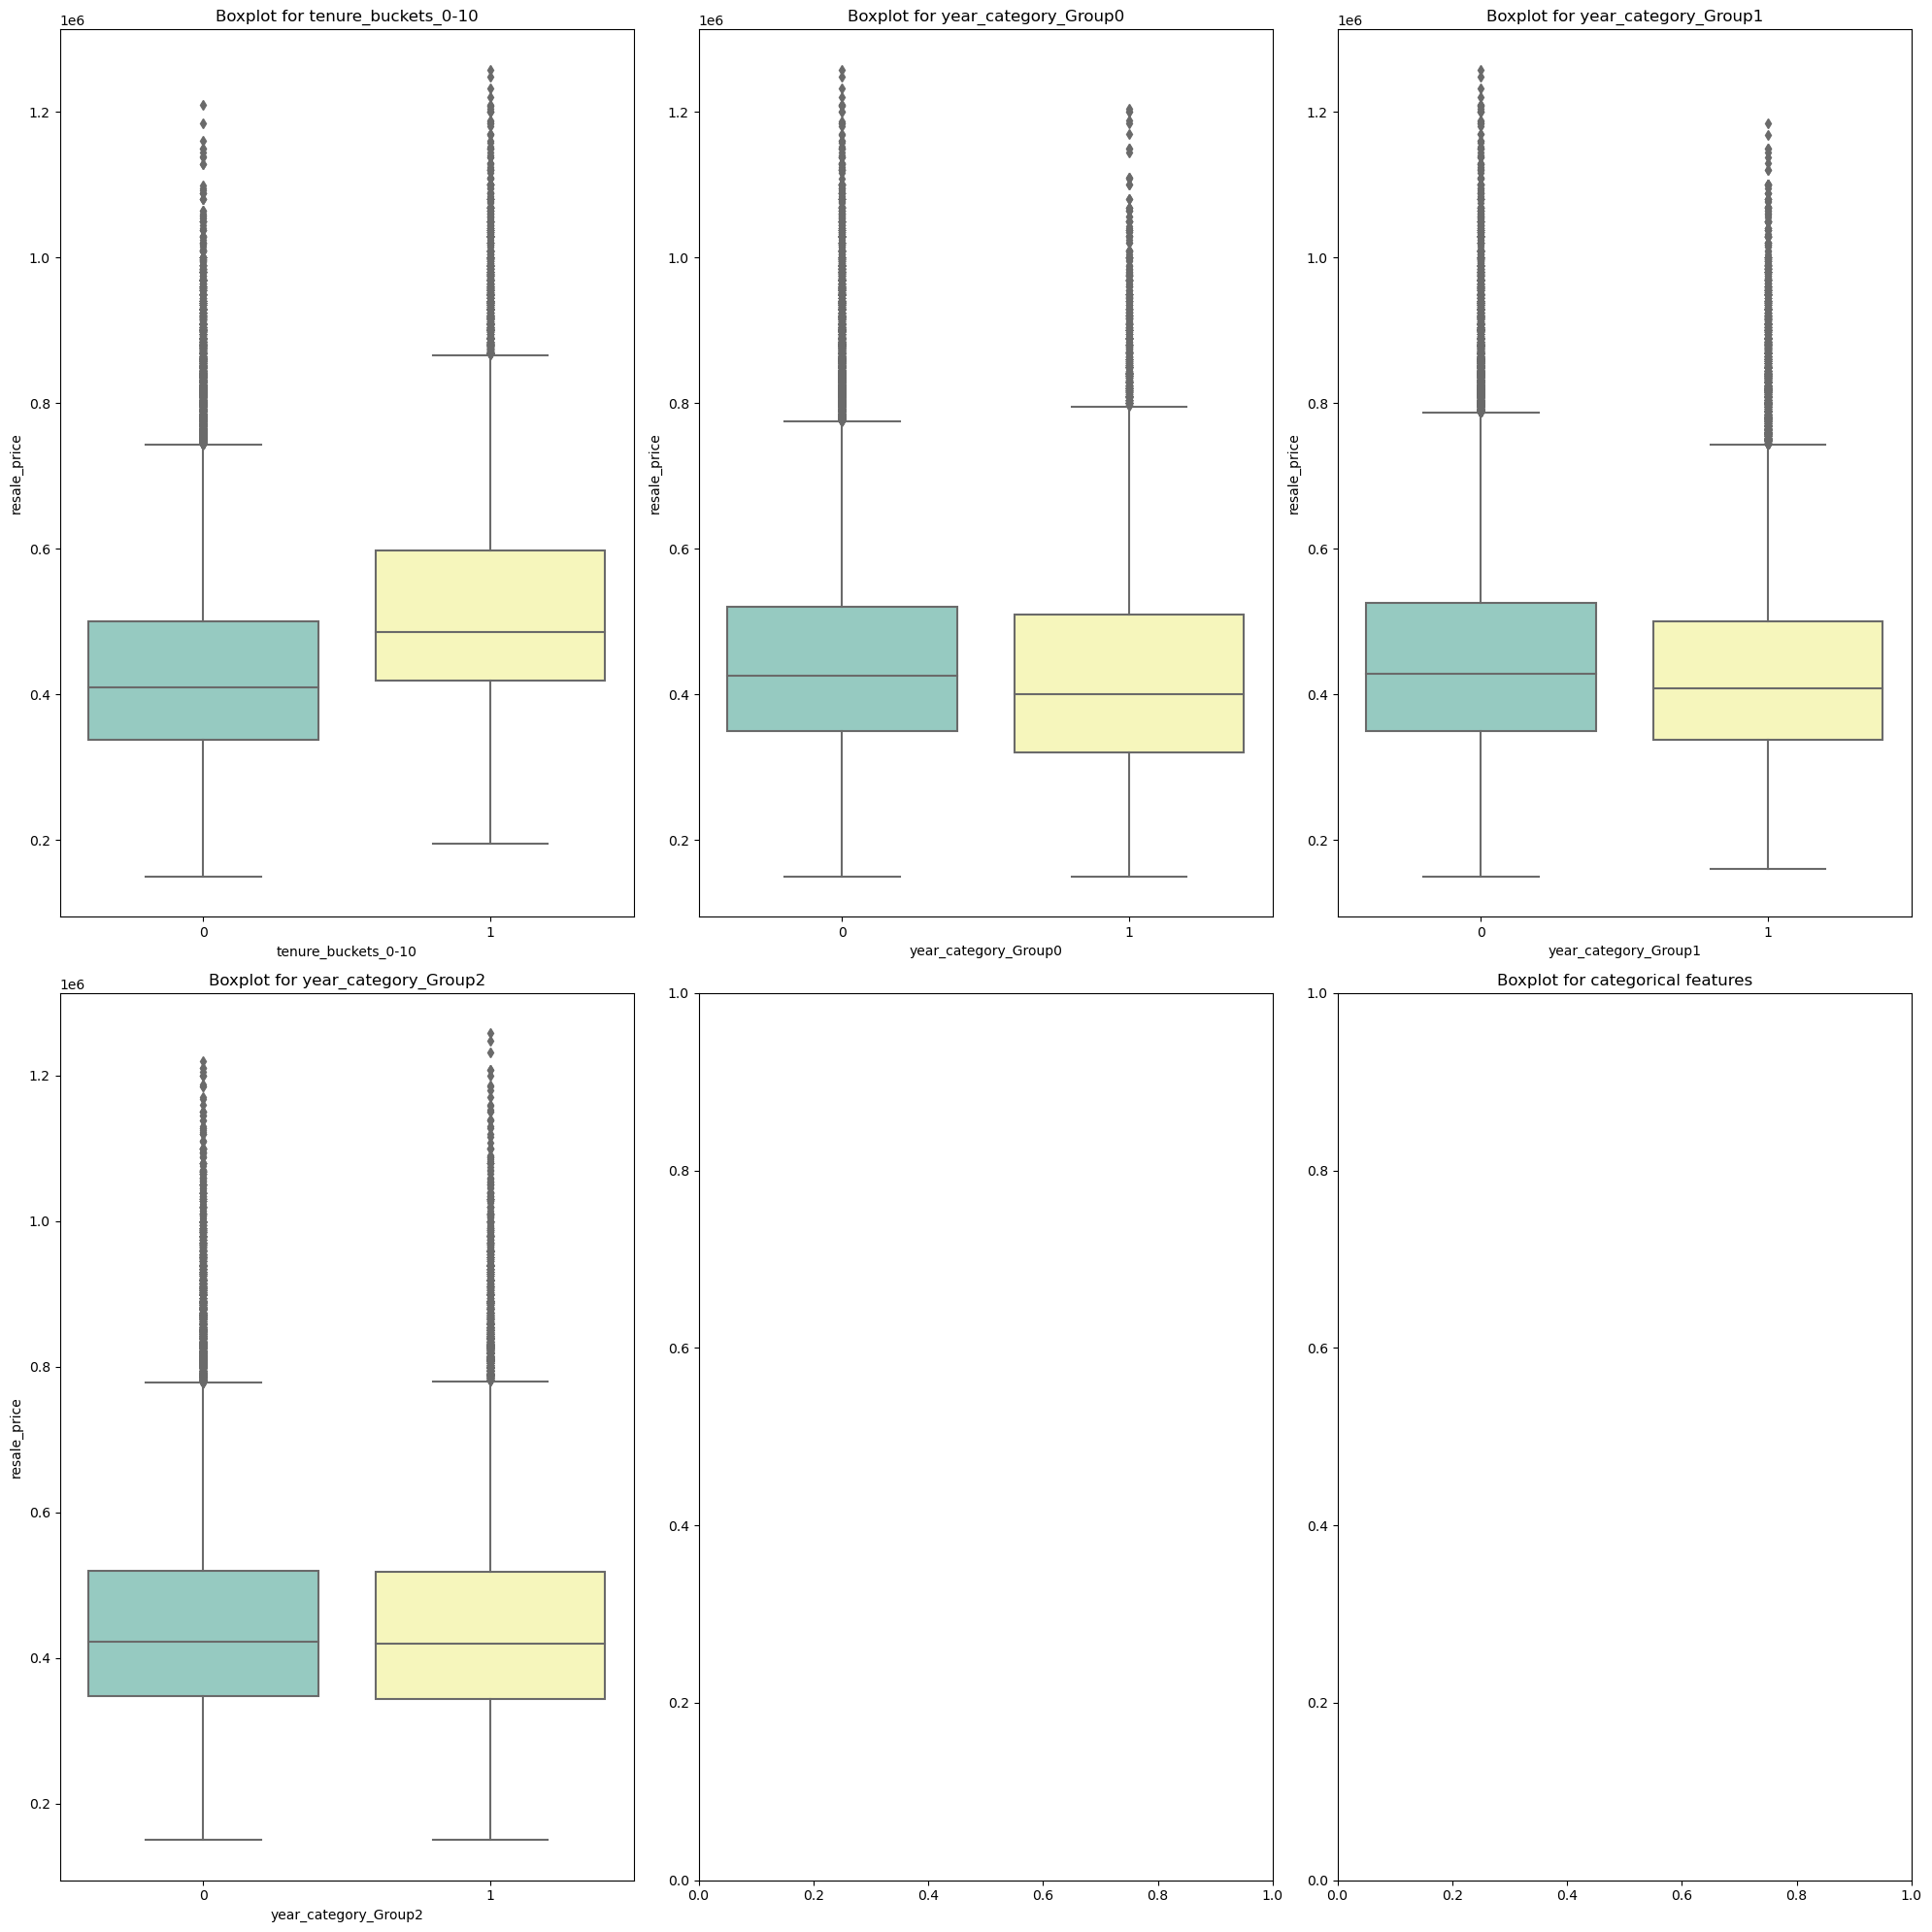

In [23]:
# Boxplots for time related features

fig, axes = plt.subplots(2, 3, figsize=(20, 20))  # Adjust rows, cols, and figsize as needed
plt.title("Boxplot for categorical features")

row_count = 0
col_count = 0


for i in [
       'tenure_buckets_0-10', 'year_category_Group0',
       'year_category_Group1', 'year_category_Group2']:
   
   sns.boxplot(data=hdb_df , x = i, y = 'resale_price', ax=axes[row_count,col_count])
   axes[row_count,col_count].set_title("Boxplot for "+i)
   col_count += 1
   if col_count == 3:
      row_count += 1
      col_count = 0

# Adjust layout
sns.set_palette("Set3")
plt.tight_layout()
plt.show()

##### Based on the above boxplots, the transaction year clearly emerges as a significant predictor of HDB resale price. The property market also plays a role in influencing resale prices.

-----------------

##### Boxplots for other binary features:-

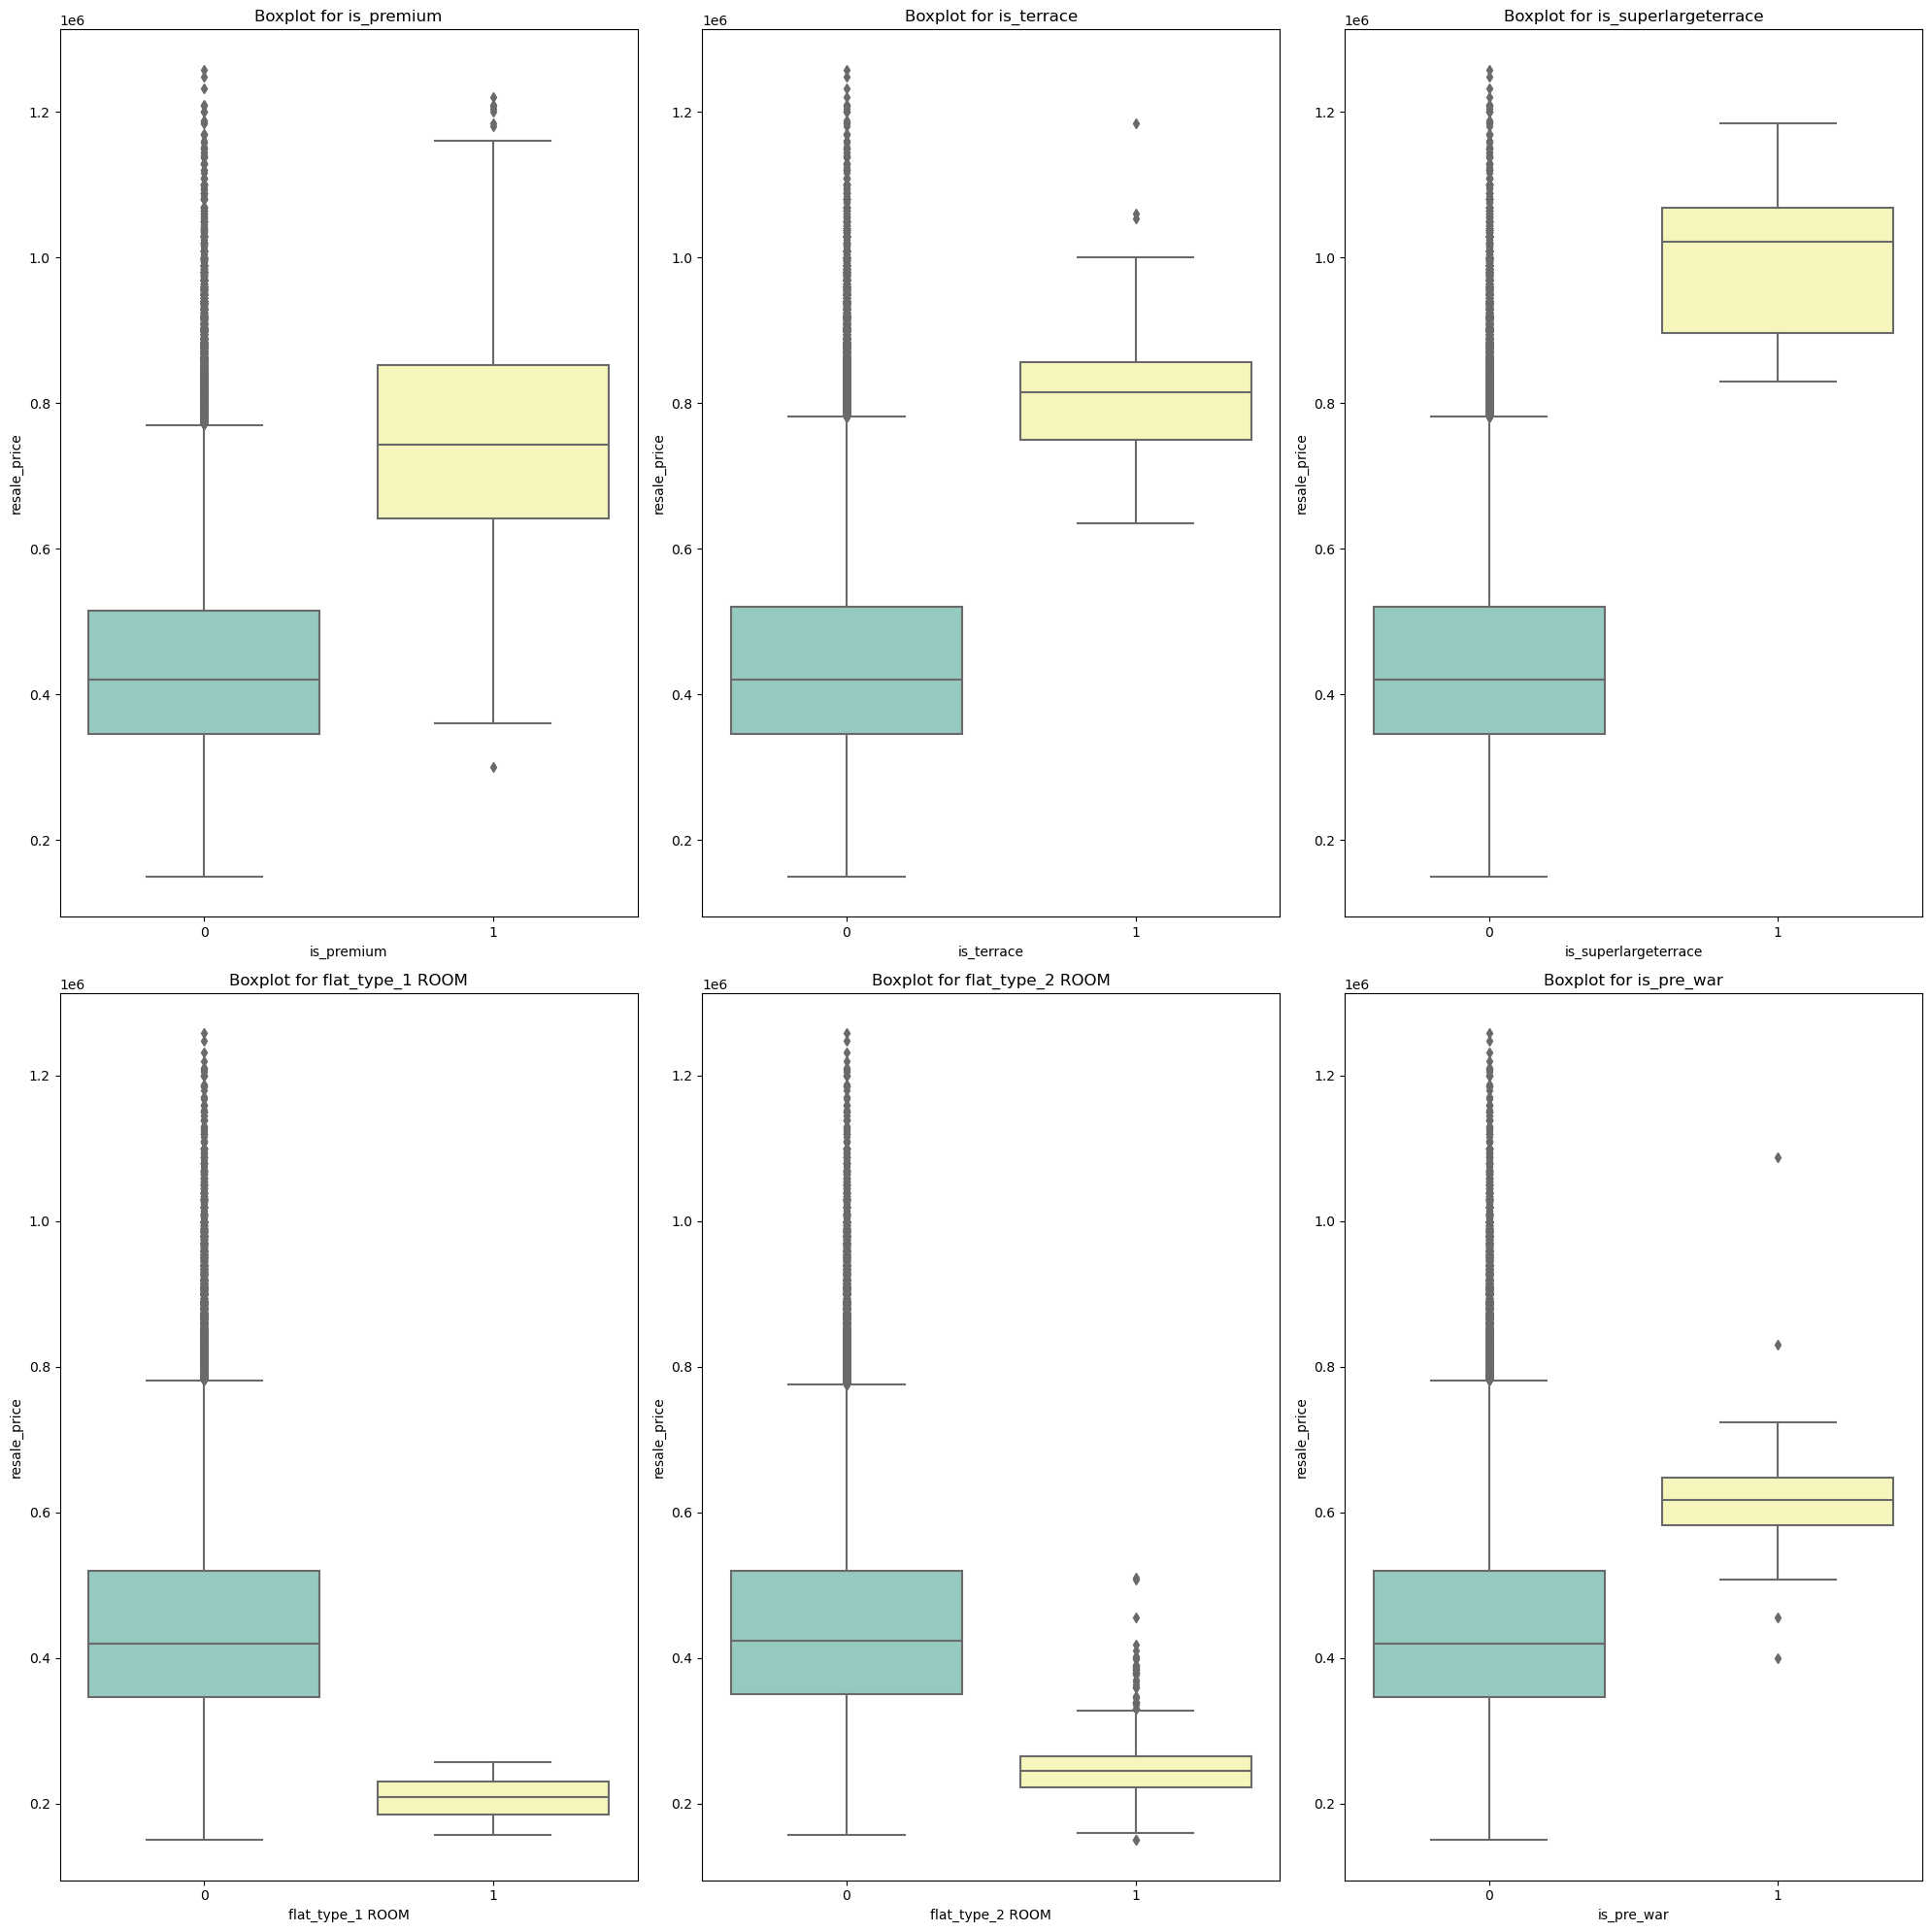

In [24]:
# Boxplots for other binary features

fig, axes = plt.subplots(2, 3, figsize=(20, 20))  # Adjust rows, cols, and figsize as needed

row_count = 0
col_count = 0


for i in [
       'is_premium',
       'is_terrace', 'is_superlargeterrace', 'flat_type_1 ROOM',
       'flat_type_2 ROOM', 'is_pre_war']:
   
   sns.boxplot(data=hdb_df , x = i, y = 'resale_price', ax=axes[row_count,col_count])
   axes[row_count,col_count].set_title("Boxplot for "+i)
   col_count += 1
   if col_count == 3:
      row_count += 1
      col_count = 0

# Adjust layout
sns.set_palette("Set3")
plt.tight_layout()
plt.show()

##### Through our comprehensive experiments, we have identified these features as significant factors influencing resale price prediction. Our model incorporates these features to achieve more accurate resale price estimations. For example, one- and two-room flat types typically have lower resale prices.
------

##### Scatter plots:

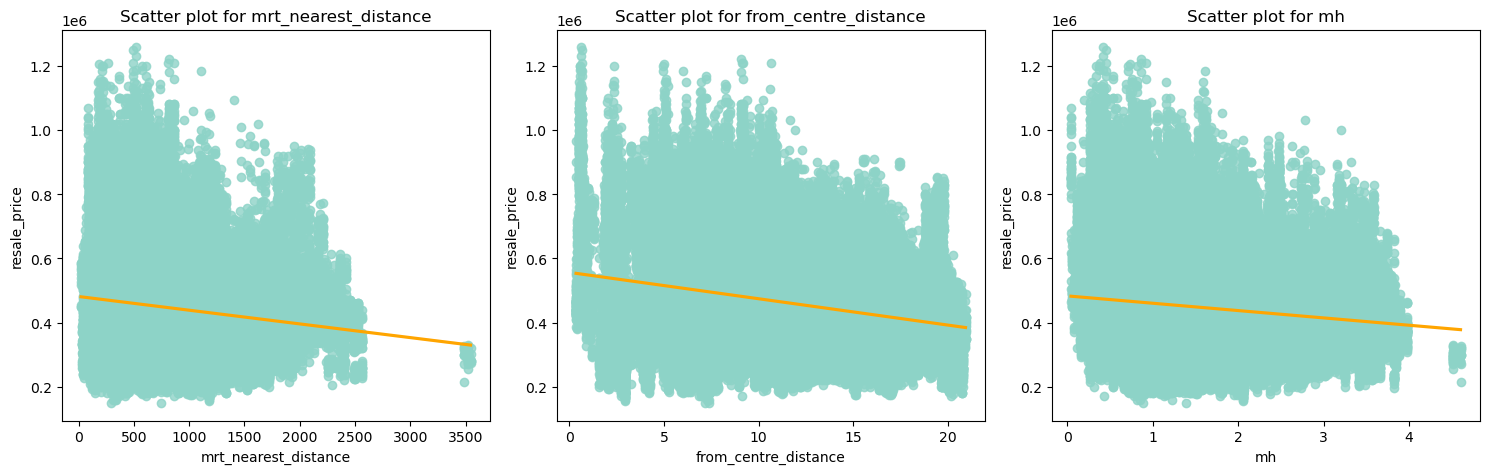

In [25]:
# Scatter plots for distance related features

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust rows, cols, and figsize as needed

col_count = 0

for i in ['mrt_nearest_distance', 'from_centre_distance', 'mh']:
   
   sns.regplot(data=hdb_df , x = i, y = 'resale_price', ax=axes[col_count], line_kws={"color":"orange"})
   axes[col_count].set_title("Scatter plot for "+i)
   col_count += 1

# Adjust layout
sns.set_palette("Set3")
plt.tight_layout()
plt.show()

##### The scatter plots for distance related features show negative correlation.

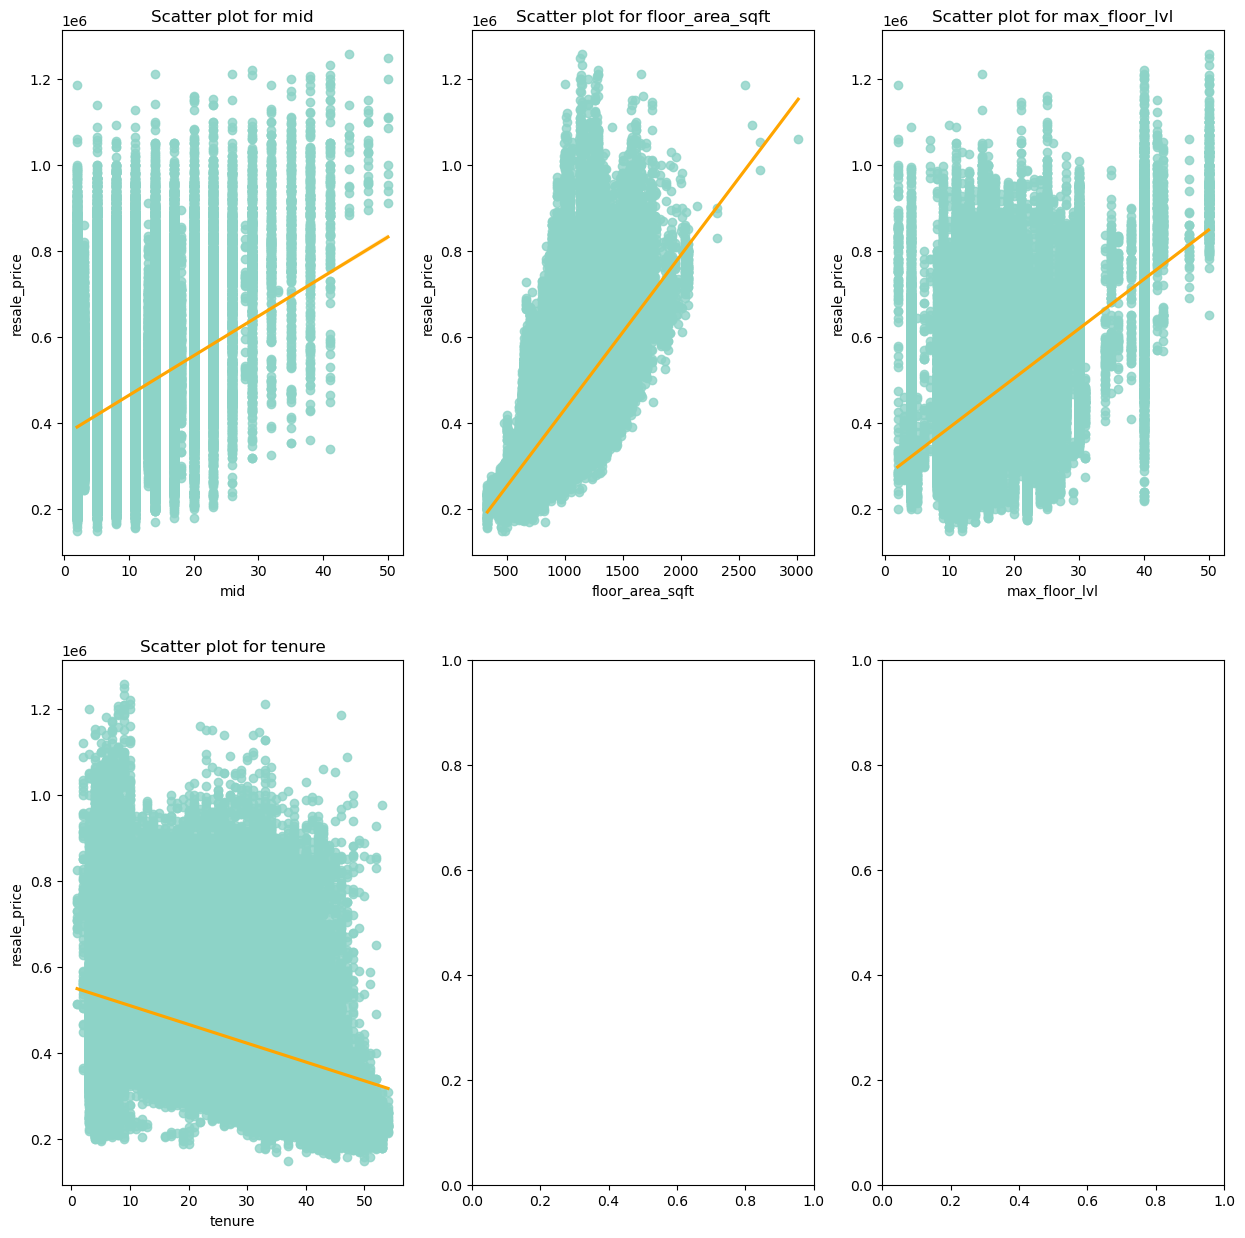

In [26]:
# Scatter plots for distance related features

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 15))  # Adjust rows, cols, and figsize as needed

row_count= 0
col_count = 0

for i in ['mid', 'floor_area_sqft','max_floor_lvl','tenure']:
   
   sns.regplot(data=hdb_df , x = i, y = 'resale_price', ax=axes[row_count, col_count], line_kws={"color":"orange"})
   axes[row_count,col_count].set_title("Scatter plot for "+i)
   col_count += 1
   
   if col_count == 3:
      row_count += 1
      col_count = 0
sns.set_palette("Set3")
plt.show()

The features above are well correlated to resale price.

### Bar charts

##### Analysis for mature estate

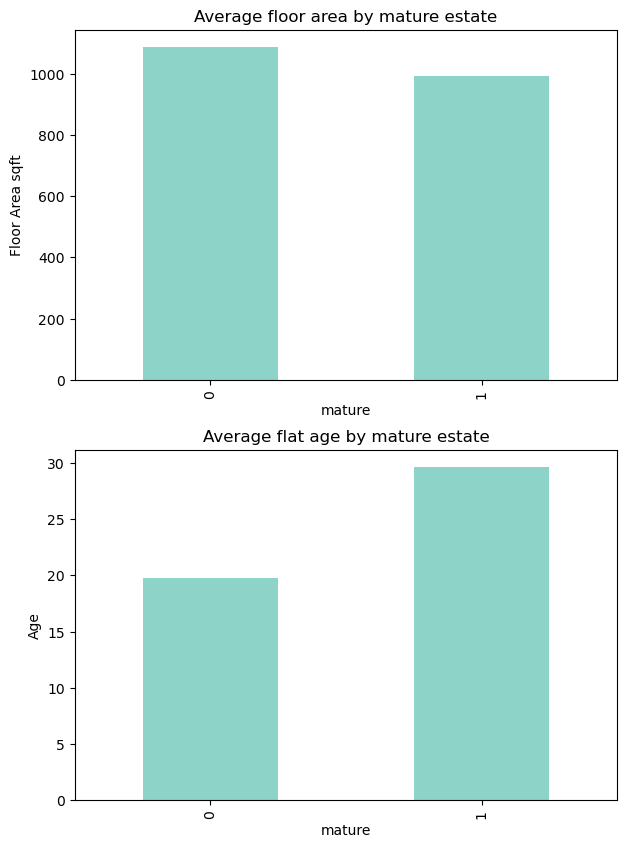

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(7,10)) 
hdb_df[['mature','floor_area_sqft']].groupby("mature").mean().plot(kind='bar',title='Average floor area by mature estate',ax=axes[0],legend=False, ylabel='Floor Area sqft')
hdb_df[['mature','tenure']].groupby("mature").mean().plot(kind='bar',title='Average flat age by mature estate', legend=False, ylabel="Age",ax=axes[1]);
sns.set_palette("Set3")

##### The average floor area of flats in mature area is smaller than non-mature area.
##### The average flat age in mature estate is older.

### Heatmap

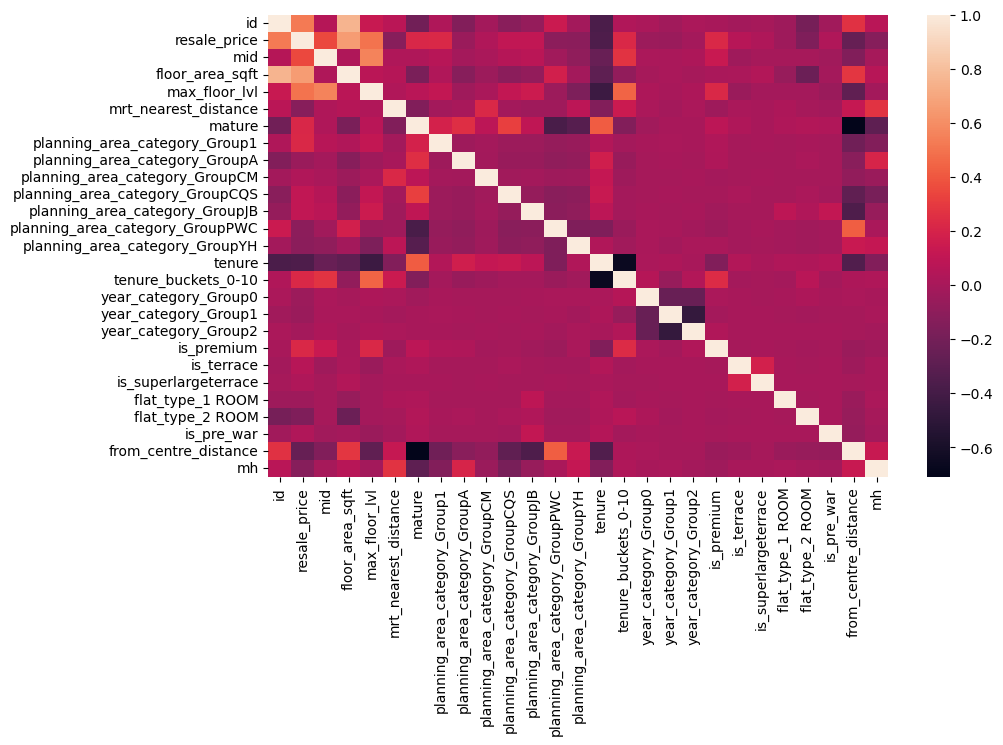

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(hdb_df.corr())
sns.set_palette("Set3")